In [87]:
#!pip install permanent

In [88]:
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

import math
import numpy as np
from numpy import sqrt, exp, cos, sin, cosh, sinh, conj
from numpy.linalg import qr
from collections import Counter
from permanent import permanent
from functools import cache

In [89]:
from typing import Tuple
# TODO: See pbs. Should we add type annotations?

# Notes

#### This is some convention used in the code below for variable names:

`gamma` = measurement threshold

`r` = squeezing strength

`N` = number of samples

`n` = number of particles

`m` = number of modes

`M` = dimension of Bosonic Hilbert space; $M := \binom{n + m - 1}{n}$

Most matrices are `m` x `N`, meaning that there is a row for each mode, and each column is one sample.

#### Section headers follow the following indentation:

\# Main Section Header

\#\# Subsection Header

\#\#\# Large group of related functions/code/markdown

\#\#\#\# Single function or tightly related code/markdown blocks

# Simulation Model: Threshold Detectors and Squeezed States

### Measurement

Detectors take in matrices of `N` samples and return boolean arrays of detection events. 

In [90]:
DEFAULT_MEAS_THRESH = 1.9494

#### `threshold_detector`
Standard many-mode threshold detector. Imagines every mode has its own detector which independently clicks if the amplitude on that mode exceeds the measurement threshold.

In [91]:
def threshold_detector(a, gamma=DEFAULT_MEAS_THRESH):
    '''Clicks if an amplitude exceeds measurement threshold.
    a : m x N complex matrix = [a_11 ... a_1N; ...; a_m1 ... a_mN]
        Each column is a sample with m components (modes)
    gamma : double = measurement threshold
    output : m x N bool array = [b_11 ... b_1N; ...; b_m1 ... b_mN]
        b_ij := (a_ij > gamma)'''

    return abs(a) > gamma

#### `h_or_v_detector`

Effectively the same as `threshold_detector(a, gamma).any(axis=0)` limited to matrices with two rows.

In [92]:
def h_or_v_detector(a: np.ndarray, gamma=DEFAULT_MEAS_THRESH):
    '''Clicks if horizontal or vertical polarization component of sample exceeds measurement threshold.
    a : 2 x N complex matrix = [h_1 ... h_n; v_1 ... v_n]
        Each column is a sample [h_i; v_i] with a horizontal and vertical polarization component
    gamma : double = measurement threshold
    output : 1 x N bool array = [b_1 ... b_n]
        b_i := (|h_i| > gamma) or (|v_i| > gamma)'''
        
    if a.shape[0] != 2:
        raise ValueError("Sample array 'a' must have 2 rows.")

    return np.bitwise_or(abs(a[0,:]) > gamma, abs(a[1,:]) > gamma)

#### `norm_detector`

Not currently used anywhere.

In [93]:
def norm_detector(a: np.ndarray, gamma=DEFAULT_MEAS_THRESH):
    '''Clicks if norm of sample exceeds measurement threshold.
    a : m x N complex matrix = [s_1 ... s_N]
        Each column is a sample s_i with m components (modes)
    gamma : double = measurement threshold
    output : 1 x N bool array = [b_1 ... b_n]
        b_i := (||s_i|| > gamma)'''
    return np.linalg.norm(a, axis=1) > gamma

#### `get_coincidence_count`

In [94]:
def get_coincidence_count(detections: np.ndarray):
    '''Returns the number of times all provided detectors simultanously clicked.
    detections : m x N bool matrix
    output : int = number of all-one columns in detections matrix'''
    return np.count_nonzero(np.sum(detections, axis=0) == detections.shape[0])

#### `get_all_coincidence_counts`

In [95]:
def get_all_coincidence_counts(detections: np.ndarray):
    '''Counts the number of times every possible detection event occurs
    A detection event is a bitstring with 1's at the indices of all detectors that 
    clicked and 0's at the indices of all detectors which did not.
    Returns a Counter object with detection events (as tuples) mapped to counts.
    Counters behave like dicts.
    detections : m x N bool matrix
    output : Dict[tuple, int] 
        Example: if output[(1,0,0)] == 21, then the event (1,0,0), aka
        "only the detector on mode 0 clicked," happened 21 times.'''
    return Counter(map(tuple, detections.T))

#### `print_all_coincidence_counts`

Exponential runtime in m, the number of modes. Linear runtime in N, the number of samples. 

Should only be used on inputs with few modes. Can be used when there are many samples.

In [96]:
def print_all_coincidence_counts(detections: np.ndarray):
    coincidence_counts = get_all_coincidence_counts(detections)
    m = detections.shape[0]
    for i in range(2**m):
        bitvector = np.frombuffer(np.binary_repr(i, width=m).encode(), dtype='S1').astype(int)
        detectors = np.binary_repr(i, width=m) # ', '.join(np.flatnonzero(bitvector).astype(str))
        print(detectors, coincidence_counts[tuple(bitvector)])

### State Preparation

#### `zpf`

In [97]:
def zpf(N: int, m=1, sigma=1/sqrt(2)):
    '''Zero-point field
    N is the number of samples
    m is the number of modes
    sigma is the standard deviation of the quantum noise
    sigma = 1/sqrt(2) corresponds to the vacuum state
    sigma > 1/sqrt(2) corresponds to a thermal state
    sigma = 0 corresponds to a classical (i.e., no ZPF) state
    
    Returns an m x N matrix of complex Gaussian random variables.'''
    
    return sigma * (np.random.normal(size=(m,N)) + 1j * np.random.normal(size=(m,N))) / sqrt(2)

#### `laser`

In [131]:
def laser(N: int, alphaH=1, alphaV=0):
    '''Laser
    alphaH and alphaV are each complex numbers
    
    Returns a 2 x N matrix of N samples of coherent light.
        Each sample has a horizontal and vertical polarization component.
        The output is identical to a zpf with the horizontal component
        offset by alphaH and the vertical component offset by alphaV.'''

    # scale of vacuum fluctations
    sigma0 = 1/sqrt(2)

    # input random variables for the entanglement source
    zH = zpf(N, 1, sigma0)
    zV = zpf(N, 1, sigma0)

    aH = alphaH + zH
    aV = alphaV + zV

    return np.concatenate((aH, aV))

#### `ent`

In [99]:
def ent(N: int, r: float, t=1, phase=0):
    '''Entanglement source
    N is the number of samples
    r is the squeezing strength (non-negative)
    t (type) is 1 or 2
    phase is in degrees.
    
    Returns a tuple of two 2 x N matrices representing entangled
        light with horizonal and vertical polarization modes.'''

    # convert degrees to radians
    phase = phase * np.pi/180
    
    #input random variables for the entanglement source
    z1H = zpf(N, 1)
    z1V = zpf(N, 1)
    z2H = zpf(N, 1)
    z2V = zpf(N, 1)

    if t == 1:
        aH = cosh(r)*z1H + sinh(r)*conj(z2H)
        aV = cosh(r)*z1V + exp(1j*phase)*sinh(r)*conj(z2V)
        bH = cosh(r)*z2H + sinh(r)*conj(z1H)
        bV = cosh(r)*z2V + exp(1j*phase)*sinh(r)*conj(z1V)
    elif t == 2:
        aH = cosh(r)*z1H + sinh(r)*conj(z2V)
        aV = cosh(r)*z1V + exp(1j*phase)*sinh(r)*conj(z2H)
        bH = cosh(r)*z2H + exp(1j*phase)*sinh(r)*conj(z1V)
        bV = cosh(r)*z2V + sinh(r)*conj(z1H)
    else:
        print(f"{t} is not a valid type.")
        return

    return np.concatenate((aH, aV)), np.concatenate((bH, bV))

### Gates 

Filters, Waveplates, and Beamsplitters

#### `ndf` (neutral density filter)

In [100]:
def ndf(a: np.ndarray, d=10):
    '''Neutral density filter
    d is the optical density (a non-negative number)'''

    if d < 0:
        raise ValueError("Optical density d must be non-negative.")

    return 10**(-d/2) @ a + (1-10**(-d/2)) @ zpf(a.shape[1], 2)

#### `hwp`

In [101]:
def hwp(a: np.ndarray, theta=0):
    '''Half-wave plate
    a is a 2 x N complex matrix
    theta is the fast-axis angle in degrees'''

    # convert degrees to radians
    theta = theta * np.pi/180

    u = np.array([
        [cos(2*theta), sin(2*theta)], 
        [sin(2*theta), -cos(2*theta)]])
        
    return u @ a

#### `qwp`

In [102]:
def qwp(a: np.ndarray, theta=0):
    '''Quarter-wave plate
    a is a 2 x N complex matrix
    theta is the fast-axis angle in degrees'''

    # convert degrees to radians
    theta = theta * np.pi/180

    u = np.array([
        [cos(theta)^2 + 1j*sin(theta)^2, (1-1j)*cos(theta)*sin(theta)], 
        [(1-1j)*cos(theta)*sin(theta), sin(theta)^2 + 1j*cos(theta)^2]])
        
    return u @ a

#### `polarizer`

In [103]:
def polarizer(a: np.ndarray, theta=0, phi=0):
    '''Polarizer
    a is a 2 x N complex matrix
    theta, phi are in degrees'''

    # convert degrees to radians
    theta = theta * np.pi/180
    phi = phi * np.pi/180

    # make projector p
    bra = np.array([cos(theta), exp(1j*phi)*sin(theta)])
    p = bra.T @ bra

    return p @ a + (np.eye(2) - p) @ zpf(a.shape[1], 2)

#### `bs`

In [104]:
def bs(a: np.ndarray, b: np.ndarray, r=1/sqrt(2)):
    '''Beam splitter
    a and b are each 2 x N complex matrices
    r is the reflectance (0 <= r <= 1)'''

    #TODO: where are the defaults / vacuum state logic? (see polarizing beam splitter)

    t = sqrt(1-r^2)

    out = np.kron(np.array([[t, r], [r, -t]]), np.eye(2)) @ np.concatenate((a, b))

    return out[0:2,:], out[2:4,:]

    # TODO: why not just 
    # u = np.array([[t, r], [r, -t]])
    # return u @ a, u @ b

#### `pbs`

In [105]:
HV = np.array([[1, 0, 0, 0], 
               [0, 0, 0, 1], 
               [0, 0, 1, 0], 
               [0, 1, 0, 0]])

DA = np.array([[1, 1, 1, -1],
               [1, 1, -1, 1], 
               [1, -1, 1, 1], 
               [-1, 1, 1, 1]])

RL = np.array([[1, -1j, 1, 1j], 
               [1j, 1, -1j, 1],
               [1, 1j, 1, -1j],
               [-1j, 1, 1j, 1]])

In [106]:
def pbs(
    a: np.ndarray = None, 
    b: np.ndarray = None, 
    basis=HV
    ) -> Tuple[np.ndarray, np.ndarray]:
    """Polarizing beam splitter
    a and b are each 2 x N complex matrices
    basis is a 4 x 4 complex matrix"""

    if a is None and b is None:
        raise ValueError("At least one input beam must be specified.")
    elif a is None:
        a = zpf(b.shape[1], 2)
    elif b is None:
        b = zpf(a.shape[1], 2)
        
    out = basis @ np.concatenate((a, b))
    
    return out[0:2,:], out[2:4,:]

## Tests

Tests are not currently comprehensive nor rigorous. Outputs need to be checked by eye.

TESTS ARE ABLE TO RUN != CODE IS WORKING CORRECTLY

### test `zpf`

In [107]:
def check_expectations(arr: np.ndarray):
    # avg z
    exp_val = arr.mean()

    # avg z^T z for every column z in arr
    # if statement optimizes speed
    trans = np.trace((arr @ arr.T if arr.shape[0] < arr.shape[1] else arr.T @ arr)) / arr.shape[1]

    # avg z^H z for every column z in arr
    herm = np.linalg.norm(arr, axis=0).mean()
    
    print(f"E[z] = {exp_val} should be 0.")
    print(f"E[z^T z] = {trans} should be 0.")
    print(f"E[z^H z] = {herm} should be 1.")

In [108]:
vac = zpf(1000000, 2)
check_expectations(vac)

E[z] = (-0.0002247998306081306-0.00023568060834682392j) should be 0.
E[z^T z] = (0.00026112631202961203-0.00047161651709359576j) should be 0.
E[z^H z] = 0.9402599325835781 should be 1.


### test `threshold_detector` and `h_or_v_detector`

In [109]:
a = zpf(100,2)

#print(a)

td = threshold_detector(a, 1)
print(td)

hv = h_or_v_detector(a, 1)
print(hv)

td_any = td.any(axis=0)
assert(np.array_equal(hv, td_any))

[[False False False False False False False False False False False  True
  False  True False False False False  True False  True False False False
  False False False  True False False False False False False False False
   True False  True False False False False False False False False False
   True False False  True False False False False  True False  True  True
  False False False False False False False False False False False  True
   True False False False False False False False False  True False False
  False False False False False False False False  True False False False
  False False False False]
 [False False False False False False False  True False False False False
   True False False False False False False False False  True False False
  False False  True  True False False False False  True False False False
  False False  True False False False  True False False False False False
   True  True False False False False False False False False False False
  False Fal

### test `ent`, `zpf`, `pbs`, coincidence counters

In [110]:
l,r = ent(1000, 2)
lzpf = zpf(1000, 2)
rzpf = zpf(1000, 2)

In [111]:
lt, lr = pbs(l, lzpf)
rt, rr = pbs(r, rzpf)

dlt, dlr, drt, drr = map(h_or_v_detector, (lt, lr, rt, rr))
detections = np.array([dlt, dlr, drt, drr])

coincidence_counts = get_all_coincidence_counts(detections)
dlt_and_drt = sum([coincidence_counts[event] for event in [(1,0,1,0), (1,0,1,1), (1,1,1,0), (1,1,1,1)]])
assert(get_coincidence_count(detections[[0,2],]) == dlt_and_drt)

print_all_coincidence_counts(detections)


0000 50
0001 1
0010 2
0011 0
0100 0
0101 160
0110 0
0111 4
1000 4
1001 0
1010 198
1011 1
1100 0
1101 7
1110 4
1111 569


## Scrap Work

Below this point is temporary test code meant to be deleted.

In [112]:
from scipy.stats import norm

distr = norm()
reals = distr.rvs(size=(50,100))
imags = distr.rvs(size=(50,100))
print(reals + 1j * imags)

[[-0.57017258-1.01464459j  1.9550901 +0.79707842j  0.11393552-0.55005109j
  ... -2.53378053-0.29435647j -1.06728931+1.13919709j
  -0.14557467+0.82421021j]
 [ 0.96149068+1.98107344j  0.05133322-0.37463674j -0.40524629+1.0268194j
  ...  2.62104733-1.07182324j -0.18535727+0.50764621j
  -0.31091939-2.43900681j]
 [ 0.09789863+1.6875222j  -1.22394964+0.13480767j -0.05053541-0.18319994j
  ... -1.00776856-0.50742077j -2.0050132 +0.07786599j
   0.53261314+1.14737904j]
 ...
 [-0.7360827 +0.58410122j -3.13060542+0.10099922j  0.3054064 +1.15302914j
  ...  1.63773722+1.83766754j  1.22096291-0.34808945j
  -0.23101309+0.55048048j]
 [ 0.48607342+1.50928802j  1.79211313-0.21385256j -2.07608613+2.10790794j
  ...  0.48589205+0.99035052j -0.94874433-0.02074404j
  -2.57522673-1.01458497j]
 [-2.10678625+0.67620721j -0.74481129+0.94927802j -0.27284685+2.24240725j
  ... -2.27261151-0.14070638j -0.1372568 +0.03916734j
   0.49428246-0.28570422j]]


In [113]:
import re
def f(s):
    s = re.sub('\s+',' ', s)
    a = [i.strip().split(' ') for i in s.split(';')]
    mat = ', '.join([f'[{", ".join(b)}]' for b in a])
    print(f'np.array([{mat}])')

In [114]:
f('''cos(theta)^2 + 1j*sin(theta)^2 (1-1j)*cos(theta)*sin(theta) (1-1j)*cos(theta)*sin(theta)   sin(theta)^2 + 1j*cos(theta)^2''')

np.array([[cos(theta)^2, +, 1j*sin(theta)^2, (1-1j)*cos(theta)*sin(theta), (1-1j)*cos(theta)*sin(theta), sin(theta)^2, +, 1j*cos(theta)^2]])


In [115]:
a = np.array([[1j,2],[3,4]])
a.mean()

(2.25+0.25j)

In [116]:
arr = zpf(1000, 2, 1)
# %timeit np.trace(arr.T @ arr) 
# %timeit np.trace(arr @ arr.T)
# %timeit np.trace((arr @ arr.T if arr.shape[0] < arr.shape[1] else arr.T @ arr)) # fastest
print(np.trace(arr.T @ arr), np.trace(arr @ arr.T))

# Output:
# 10.1 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# 15 µs ± 1.97 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
# 12.7 µs ± 295 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

(-85.76021587059009-34.70302336155132j) (-85.76021587059009-34.703023361551296j)


In [117]:
print(np.eye(2) * np.ones((2,2)))           # elementwise product
print(np.eye(2) @ np.ones((2,2)))           # matrix product
print(np.kron(np.eye(2), np.ones((2,2))))   # kronecker product

[[1. 0.]
 [0. 1.]]
[[1. 1.]
 [1. 1.]]
[[1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]]


# Simulation Model: QM

### Fock States

#### `is_fock_state`

In [118]:
def is_fock_state(np_arr):
    return all([(i.is_integer() and i >= 0) for i in np_arr])

#### `get_fock_basis_states`

This function was written recursively with memoization (see `@cache`) in order to make it faster. The tradeoff is that it rapidly fills up computer memory with cached data.

Even with memoization, this function's runtime is worse than exponential in n, the number of particles. 

Use sparingly, and only on inputs with small n.


In [119]:
@cache
def get_fock_basis_states(n, m):
  '''Returns a numpy array of all (n + m - 1 Choose n) Fock basis 
  states with n particles in m modes.'''

  if not isinstance(n, int) or n < 0:
    raise ValueError("n must be a non-negative integer")
  if not isinstance(m, int) or m < 1:
    raise ValueError("m must be a positive integer")

  if m == 1:
    return np.array([[n]], dtype=int)
  if n == 1:
    return np.eye(m, dtype=int)

  states = None
  for i in range(0,n+1):
    sub_states = get_fock_basis_states(n-i, m-1)
    first_mode = np.full((sub_states.shape[0],1), i)
    new_states = np.concatenate((first_mode, sub_states), axis=1)
    if i == 0:
      states = new_states
    else:
      states = np.concatenate((states, new_states))
  return states
     

### Unitaries

#### `HilbertSpaceUnitary`

Recall 

$$\langle S | \varphi (U) | T \rangle = \frac{Per(U_{S,T})}{\sqrt{s_1! \dots s_m! t_1! \dots t_m!}}$$

See pg 95 of https://www.scottaaronson.com/qisii.pdf for more info.

In [120]:
class HilbertSpaceUnitary(object):
  '''Converts the m x m unitary of a linear optical network to 
  the larger M x M unitary acting on the entire Hilbert space,
  where M := n+m-1 choose n. Lazily computes entries as needed.'''

  def __init__(self, U, n):
    self.U = U # U should be an m x m unitary
    self.n = n
    self.entries = {}
    self.factorial = np.vectorize(math.factorial) 
    # Assuming few collisions, this should be fine. With high photon counts, we 
    # might consider memozing our factorial function.

  def get_entry(self, S, T):
    '''This gives the entry <S|\phi(U)|T>, that is,
    the amplitude of a T to S transition.
    S and T must both be Fock states.'''

    if np.sum(S) != self.n or np.sum(T) != self.n:
      raise ValueError(f"Fock states must have {self.n} particles.")
    if not is_fock_state(S):
      raise ValueError("S must be a Fock state.")
    if not is_fock_state(T):
      raise ValueError("T must be a Fock state.")

    key = (S.tobytes(),T.tobytes())
    if key not in self.entries:
      U_ST = np.repeat(np.repeat(self.U, S, axis=0), T, axis=1).astype(complex)
      self.entries[key] = ( 
          permanent.permanent(U_ST) 
          / sqrt(np.prod(self.factorial(S)))
          / sqrt(np.prod(self.factorial(T)))
      ) # watch out for multiplication overflows on normalization factor
    return self.entries[key]
  
  def __getitem__(self, S_and_T):
    '''Makes object subscriptable.
    self[S,T] is equivalent to self.get_entry(S,T)'''
    S,T = S_and_T
    return self.get_entry(S,T)

#### `get_hilbert_space_unitary_matrix`

Exponential runtime - use only if you need to see the whole hilbert space unitary matrix at once. 

When possible, use HilbertSpaceUnitary to calculate entries lazily instead.

In [121]:
def get_hilbert_space_unitary_matrix(U, n, p=False):
  '''Converts the m x m unitary of a linear optical network to 
  the larger M x M unitary acting on the entire Hilbert space.
  U is an m x m unitary (m is number of modes)
  n is number of particles
  p determines whether or not to print the matrix
  M := n+m-1 choose n'''
  m = U.shape[0]
  basis_states = get_fock_basis_states(n,m)
  hsu = HilbertSpaceUnitary(U, n)
  M = basis_states.shape[0]
  hsu_matrix = np.zeros((M,M), dtype=complex)
  for i in range(M):
    for j in range(M):
      hsu_matrix[i,j] = hsu.get_entry(basis_states[i], basis_states[j])
  if p:
    rounded_hsu = np.around(hsu_matrix,2)
    for i in range(M):
      print(basis_states[i], end=':\t')
      print(rounded_hsu[i])
  return hsu_matrix

#### `qr_haar`

In [122]:
# Source: https://pennylane.ai/qml/demos/tutorial_haar_measure.html

def qr_haar(m):
    """Generate a Haar-random matrix using the QR decomposition.
    m is the number of modes."""
    # Step 1
    A, B = np.random.normal(size=(m, m)), np.random.normal(size=(m, m))
    Z = A + 1j * B

    # Step 2
    Q, R = qr(Z)

    # Step 3
    Lambda = np.diag([R[i, i] / np.abs(R[i, i]) for i in range(m)])

    # Step 4
    return np.dot(Q, Lambda)

## Tests

Tests are not currently comprehensive nor rigorous. Outputs need to be checked by eye.

TESTS ARE ABLE TO RUN != CODE IS WORKING CORRECTLY

### test `get_fock_basis_states`

Takes a long time and eats up memory very quickly. The advantage of using `@cache` can be seen by running `get_fock_basis_states` twice in a row, or running it with smaller inputs after it finishes - after the first run, future calls are almost instantaneous.

In [123]:
# get_fock_basis_states(3,100)

### test `qr_haar` and `HilbertSpaceUnitary`

In [124]:
U = qr_haar(100) #np.array([[0, 1], [1, 0]], dtype=complex)

#print(U)

UH = HilbertSpaceUnitary(U, 1)

zers = np.zeros(100, dtype=int)
zert = np.zeros(100, dtype=int)

zers[0] = 1
zert[0] = 1

print(abs(UH.get_entry(zers, zert))**2)
print(abs(UH[zers, zert])**2)

0.0014924225988723592
0.0014924225988723592


### test `get_hilbert_space_unitary_matrix`

In [130]:
hadamard = np.array([[1, 1], [1, -1]]) / sqrt(2)

print("Hadamard with 1 photon, 2 modes:")
hsu_had = get_hilbert_space_unitary_matrix(hadamard, 1, p=True) # p=True prints resulting unitary
print()

print("Hadamard with 2 photons, 2 modes:")
hsu_had = get_hilbert_space_unitary_matrix(hadamard, 2, p=True)
print()

m = 6
U = qr_haar(m)

print(f"Haar random unitary with 1 photon, {m} modes:")
hsu_haar = get_hilbert_space_unitary_matrix(U, 1, p=True)
print()

print(f"Haar random unitary with 2 photons, {m} modes:")
hsu_haar = get_hilbert_space_unitary_matrix(U, 2, p=True)
print()

Hadamard with 1 photon, 2 modes:
[1 0]:	[0.71-0.j 0.71-0.j]
[0 1]:	[ 0.71-0.j -0.71+0.j]

Hadamard with 2 photons, 2 modes:
[0 2]:	[ 0.5 +0.j -0.71+0.j  0.5 +0.j]
[1 1]:	[-0.71+0.j  0.  +0.j  0.71+0.j]
[2 0]:	[0.5 +0.j 0.71+0.j 0.5 +0.j]

Haar random unitary with 1 photon, 6 modes:
[1 0 0 0 0 0]:	[ 0.06+0.38j  0.29-0.01j -0.28-0.32j -0.34+0.05j -0.34+0.49j  0.31+0.1j ]
[0 1 0 0 0 0]:	[-0.52+0.03j  0.24-0.38j -0.07+0.51j  0.34+0.09j -0.26+0.1j   0.19+0.15j]
[0 0 1 0 0 0]:	[ 0.49-0.08j -0.31+0.03j  0.06+0.13j  0.18+0.13j -0.14-0.04j  0.36+0.66j]
[0 0 0 1 0 0]:	[-0.18+0.09j -0.23+0.37j -0.13+0.59j -0.61-0.09j  0.1 -0.02j  0.11+0.07j]
[0 0 0 0 1 0]:	[ 0.5 -0.07j  0.5 -0.01j  0.09+0.37j -0.02-0.51j -0.21+0.01j -0.18-0.07j]
[0 0 0 0 0 1]:	[ 0.08-0.16j -0.39+0.16j  0.  +0.14j  0.08+0.23j -0.6 +0.36j -0.37-0.28j]

Haar random unitary with 2 photons, 6 modes:
[0 0 0 0 0 2]:	[ 0.06+0.21j  0.46+0.05j  0.23-0.44j -0.19-0.15j  0.05-0.15j -0.05+0.04j
 -0.05+0.02j -0.08-0.12j  0.05-0.08j -0.02+0.j   

# Experiments

### Spoof Haar

```
                       ┌─────────────┐
[Detector] ◄──[ent]──► │             │──► [Detector]
[Detector] ◄──[ent]──► │             │──► [Detector]
[Detector] ◄──[ent]──► │ Haar-Random │──► [Detector]
[Detector] ◄──[ent]──► │   Unitary   │──► [Detector]
[Detector] ◄──[ent]──► │             │──► [Detector]
[Detector] ◄──[ent]──► │             │──► [Detector]
                       └─────────────┘
```

In [126]:
def spoof_haar(num_src, N=1000):
    m = 2*num_src
    ents = [ent(N, r=1) for i in range(num_src)]
    l_ents = np.concatenate(tuple([ent[0] for ent in ents]))
    r_ents = np.concatenate(tuple([ent[1] for ent in ents]))
    haar_U = qr_haar(m)
    r_ents = haar_U @ r_ents
    return threshold_detector(l_ents), threshold_detector(r_ents)

[[ True False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ...  True False False]
 [False False False ... False False False]
 [False False False ...  True False False]]


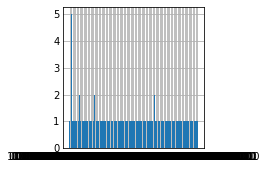

In [127]:
l_res, r_res = spoof_haar(10, N=100)
print(l_res)

def tup_to_bin(tup):
    return "".join(str(int(item)) for item in tup)

lcounts = get_all_coincidence_counts(l_res)
sortedCounts = []
bins = []
counts = []
for tup in lcounts:
    bins.append(tup_to_bin(tup))
    counts.append(lcounts[tup])
    sortedCounts.append((lcounts[tup], tup_to_bin(tup)))
plt.bar(bins, counts)
plt.show()
# print(sorted(sortedCounts, reverse=True))
# print(get_all_coincidence_counts(r_res))
# print_all_coincidence_counts(l_res)
# print_all_coincidence_counts(r_res)

In [69]:
print(ent(17,r=1))

(array([[-0.74099294+0.16184481j,  0.21287508+1.91419989j,
         0.71838481-0.57196803j,  1.0773436 -0.33571333j,
        -0.5446664 +1.62237974j,  0.27392988-0.84154139j,
        -0.88561892+0.65372563j, -0.0707417 -1.33824528j,
        -0.14346415+1.63254198j, -0.23777257-0.90908239j,
         0.276396  +0.79686222j, -1.00124541+0.10690834j,
        -1.50910459-0.97732892j, -0.9099713 -0.31031501j,
        -0.34664532-0.20665061j,  1.15847376+1.11686945j,
         1.01320523-1.30062745j],
       [-0.62269306-0.97079359j, -1.70721335-0.96663417j,
        -0.22977587+1.9751126j ,  0.99168193-1.00549399j,
        -1.15276319+1.16469594j, -1.00128802+0.47625497j,
         0.01759188+2.46703329j,  0.21705338-1.24036086j,
        -0.96527358-1.1083993j , -0.08394024-0.74964804j,
         0.17550755-1.03158761j, -1.87344845+1.13386307j,
        -0.64876164-0.42742245j, -0.73505726+0.86843706j,
         2.75342294-0.03561887j,  1.24477757-0.54179433j,
        -1.97358324+0.74857973j]]), a